## The following Code will run with Google Cloud AI Platform Notebooks

### Create plot functions

In [90]:
import matplotlib.pyplot as plt
import pandas as pd

In [91]:
def plot_historical_and_forecast(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None):
  input_timeseries = input_timeseries.sort_values(timestamp_col_name)    

  plt.figure(figsize=(20,6))
  plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
  plt.xlabel(timestamp_col_name)
  plt.ylabel(data_col_name)

  if forecast_output is not None:
    forecast_output = forecast_output.sort_values('forecast_timestamp')
    forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
    x_data = forecast_output['forecast_timestamp']
    y_data = forecast_output['forecast_value']
    confidence_level = forecast_output['confidence_level'].iloc[0]  * 100
    low_CI = forecast_output['confidence_interval_lower_bound']
    upper_CI = forecast_output['confidence_interval_lower_bound']
    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
    # Shade the confidence interval
    plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = str(confidence_level) + '% confidence interval')

  # actual
  if actual is not None:
    actual = actual.sort_values(timestamp_col_name)
    plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

  # Display legend
  plt.legend(loc = 'upper center', prop={'size': 16})

## Plot the time series

###  Downloaded carbon emission data by geo lcation in JSON format with google serverless function, which is running with google cloud scheduler to extract data on a daily basis via the watttimes API calls, starting on 01/21/2021. The downloaded data is then stored in the GCP bucket and uploaded into BigQuery data table in the watttimes_data dataset via the BigQuery data transfer service on demand with pub/sub trigger.Below will show the how to predict carbon emission with the past months data.

In [96]:
%%bigquery df
SELECT
   CAST(EXTRACT(date from point_time) AS TIMESTAMP) AS date
   , Sum(Value) AS CarbonEmission
FROM
  `key-prism-314302.watttimes_data.data`
WHERE datatype='MOER'
GROUP BY date
HAVING date BETWEEN '2019-01-01' AND '2019-02-15'
ORDER BY date

Downloading: 100%|██████████| 26/26 [00:01<00:00, 19.60rows/s]


In [97]:
df.head()

,date,CarbonEmission
0,2019-01-21 00:00:00+00:00,538758.0
1,2019-01-22 00:00:00+00:00,553550.0
2,2019-01-23 00:00:00+00:00,493764.0
3,2019-01-24 00:00:00+00:00,473526.0
4,2019-01-25 00:00:00+00:00,569584.0


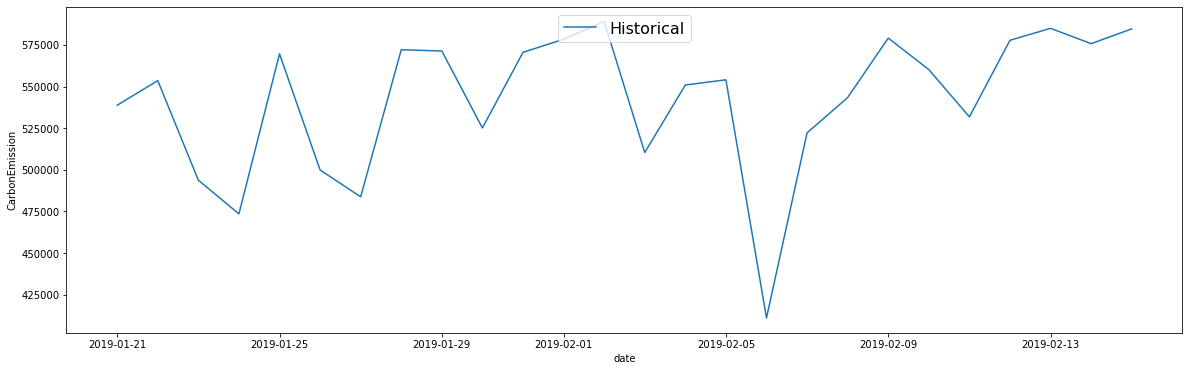

In [98]:
plot_historical_and_forecast(df, 'date', 'CarbonEmission');

## Train ARIMA model for time series forecast

In [104]:
%%bigquery
CREATE OR REPLACE MODEL bqml_timeseries.carbon_forecast
OPTIONS(model_type='ARIMA',
        time_series_data_col='CarbonEmission',
        time_series_timestamp_col='date') AS

SELECT
   CAST(EXTRACT(date from point_time) AS TIMESTAMP) AS date
   , Sum(Value) AS CarbonEmission
FROM
  `key-prism-314302.watttimes_data.data`
WHERE datatype='MOER'
GROUP BY date
HAVING date BETWEEN '2019-01-01' AND '2019-02-15'

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1501.18query/s]                        


""


In [108]:
%%bigquery fcst
SELECT * FROM
  ML.FORECAST(MODEL bqml_timeseries.carbon_forecast,
                      STRUCT(45 AS horizon, 0.9 AS confidence_level))

Downloading: 100%|██████████| 45/45 [00:01<00:00, 31.05rows/s]


In [109]:
fcst.head()

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2019-02-16 00:00:00+00:00,542503.846154,42124.649816,0.9,473290.0483,611717.644008,473290.0483,611717.644008
1,2019-02-17 00:00:00+00:00,542503.846154,42124.649816,0.9,473290.0483,611717.644008,473290.0483,611717.644008
2,2019-02-18 00:00:00+00:00,542503.846154,42124.649816,0.9,473290.0483,611717.644008,473290.0483,611717.644008
3,2019-02-19 00:00:00+00:00,542503.846154,42124.649816,0.9,473290.0483,611717.644008,473290.0483,611717.644008
4,2019-02-20 00:00:00+00:00,542503.846154,42124.649816,0.9,473290.0483,611717.644008,473290.0483,611717.644008


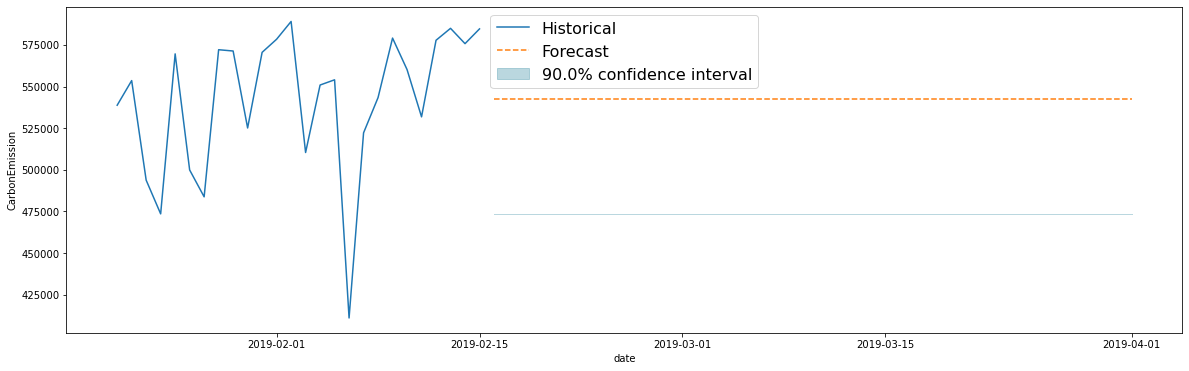

In [110]:
plot_historical_and_forecast(df, 'date', 'CarbonEmission', fcst);